# Iris Flower Dataset

This document presents the production of explanations using MeLIME method for a Random Forest (RF) model trained on the Iris Flower Dataset (regarding the dataset, please see https://en.wikipedia.org/wiki/Iris_flower_data_set). The produced explanations are compared with LIME methodology.

This notebook compares the LIME with MeLIME results. You will need to have LIME installed with you would like to obtain LIME explanations, you can do that by:
> pip install lime

In [1]:
import sys,os
# sys.path.append('..')

import pickle
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import datasets
import sklearn.ensemble
from sklearn import metrics
from matplotlib import pyplot as plt

import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split


import lime

from sklearn.pipeline import make_pipeline

from nnlocallinear import NLS, LLS, NNPredict
from explainers.visualizations.plot_importance import ExplainGraph
from explainers.visualizations.visualization import GridPlot


# Load Data 

In [2]:
data = datasets.load_iris()
x_all = data.data
y_all = data.target
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, train_size=0.80, random_state=123)

# Training a RF Model

In [5]:
def comb(a,b):
    c = []
    for i in a:
        for j in b:
            c.append(np.r_[i,j])
    return np.array(c)

def explain(penalization_thetas=0.0):
    parameters = {
            'es_give_up_after_nepochs': 20
            , 'hidden_size': 100
            , 'num_layers': 4
            , 'n_classification_labels': 3
            , 'penalization_thetas': penalization_thetas
        }

    model = NLS(
            verbose=0
            , es=True
            , gpu=True
            , scale_data=False
            , varying_theta0=False
            , fixed_theta0=False
            , dataloader_workers=0
            , **parameters
        ) 
    model.fit(x_train=x_train, y_train=y_train)
    print('R2: ', metrics.r2_score(y_test, model.predict(x_test)))
    print('MSE: ', metrics.mean_squared_error(y_test, model.predict(x_test)))

    def predict(x):
        return model.predict(x)

    def predict_prob(x):
        return model.predict_proba(x)

    def get_explanation(x_explain, document, num_features=10):
        
        explanation = model.get_thetas(x_pred=x_explain, net_scale=True)
        betas = explanation[2][0]

        print(betas.shape)
        if betas.shape[1] > 1:
            # Prediction from the model
            prediction = model.predict(x_explain).reshape(-1)
            predict_proba = model.predict_proba(x_explain).reshape(-1)
            print('probabilities:', predict_proba)
            ind_pred_proba = np.argsort(predict_proba)[::-1]
            print('probabilities: ', ind_pred_proba)
        
            # col_betas = int(prediction)
            col_betas = ind_pred_proba[0]
            col_betas_neg = ind_pred_proba[1]

            betas_document = betas[:, col_betas]
            print('betas_document len:', len(betas_document))
            betas_document_neg = betas[:, col_betas_neg]
            betas = betas_document - betas_document_neg
        
        # Prediction from the model
        prediction = model.predict(x_explain).reshape(-1)
        

        
        return dict(
            chi_names=data.feature_names,
            chi_values=x_explain,
            x_values=x_explain,
            x_names=data.feature_names,
            y_p=predict_prob(x_explain)[0][col_betas],
            y_p_max=100.0,
            y_p_min=0.0,
            y_p_local_model=predict_prob(x_explain)[0][col_betas],
            y_p_local_model_max=None,
            y_p_local_model_min=None,
            error=None,
            importances=betas, 
            diff_convergence_importances=None,
            ind_class_sorted=0,
            class_names= ["prob"]
        )
    
    # x_explain = np.array([[6.0, 3., 5, 1.5]])
    # y_explain = 1   
    x_explain = x_test[0].reshape(1, -1)
    y_explain = y_test[0]
    print("x_explain:", x_explain)
    print("y_explain:", y_explain)
    print(f'Predict y: {model.predict(np.array(x_explain))[0][0]:5.4f}')    
    
    ####
    # Code to plot the data and the instance that we want to explain.
    y_all_pred = model.predict(data.data)

    x = data.data
    y = y_all_pred
    y_names = {i:name for i, name in enumerate(data.target_names)}
    colors = ['#558F17', '#4F6DDB', '#DE613E']
    axis, _ = GridPlot.plot(
        x=data.data, x_cols_name=data.feature_names, y=y_all_pred, y_names=y_names, colors=colors, alpha=0.8)
    GridPlot.plot_instance(x_explain[0], axis)
    for ax in axis.ravel():
        start, end = ax.get_xlim()
        stepsize = 1
        ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))
    plt.savefig('grid_model_predictions.pdf')


    explain_dict = get_explanation(x_explain, x_explain, num_features=13)
    explain_dict['y_p']
    fig, axs = ExplainGraph.plot(explain_dict)
    plt.savefig(f'iris_pt_{penalization_thetas}.png', dpi=300)

In [ ]:
 explain(e)

##############################
penalization_thetas:  0.0
R2:  0.958100558659218
MSE:  0.03333333333333333
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 1.0000
(4, 3)
probabilities: [2.4573414e-19 9.9982446e-01 1.7556470e-04]
probabilities:  [1 2 0]
betas_document len: 4


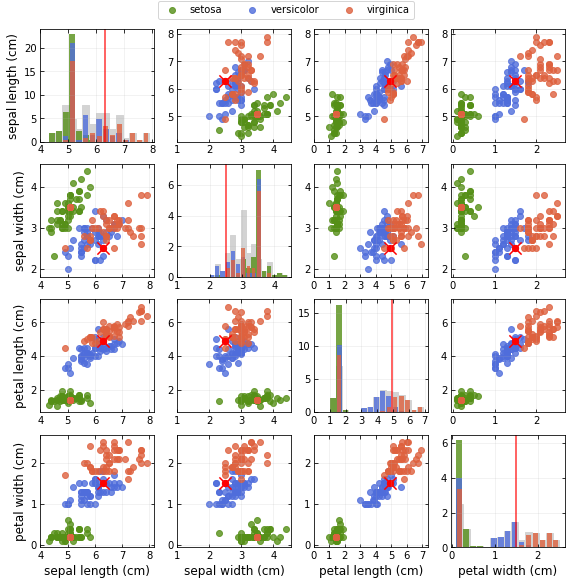

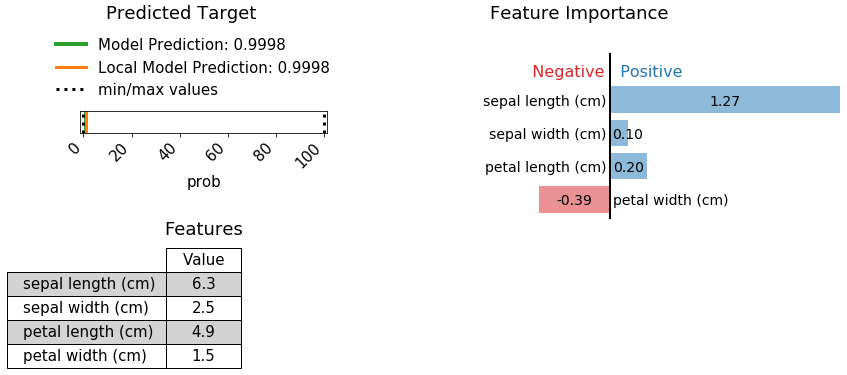

##############################
penalization_thetas:  0.01
R2:  0.958100558659218
MSE:  0.03333333333333333
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 1.0000
(4, 3)
probabilities: [9.6342476e-13 9.9609715e-01 3.9028598e-03]
probabilities:  [1 2 0]
betas_document len: 4


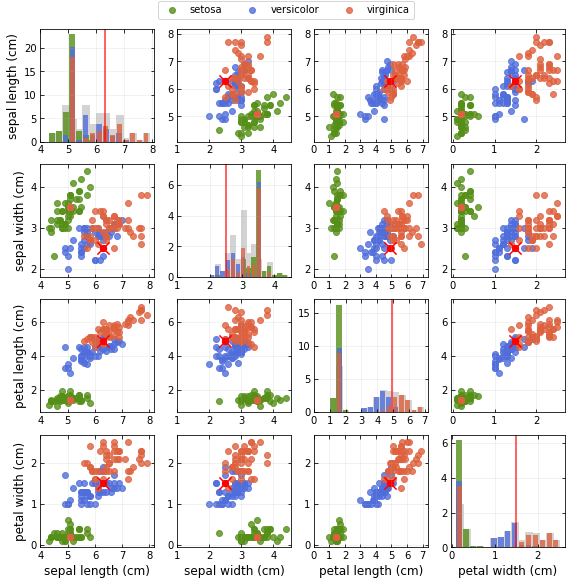

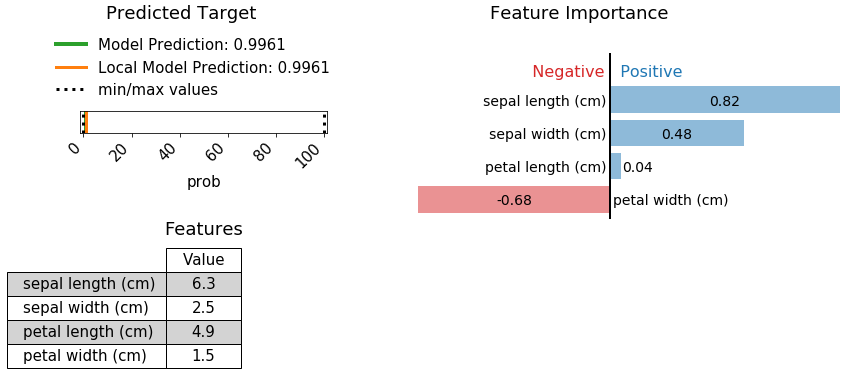

##############################
penalization_thetas:  0.1
R2:  0.28770949720670413
MSE:  0.5666666666666667
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 1.0000
(4, 3)
probabilities: [2.7940935e-04 6.9506663e-01 3.0465400e-01]
probabilities:  [1 2 0]
betas_document len: 4


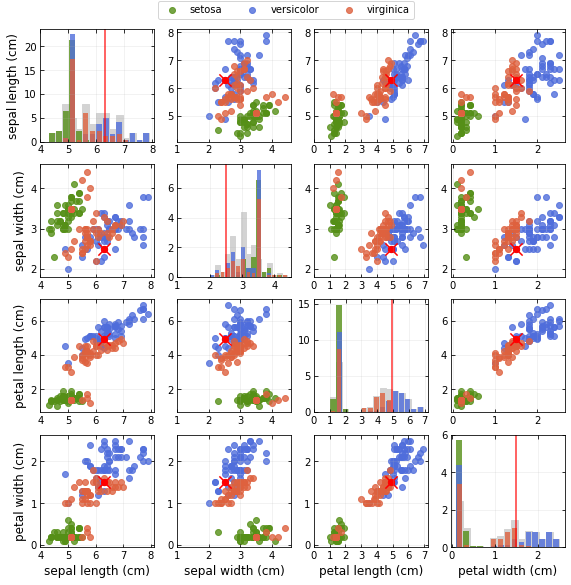

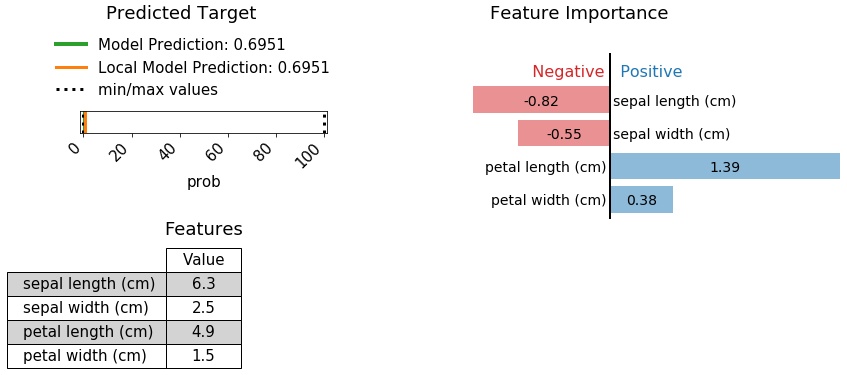

##############################
penalization_thetas:  0.2
R2:  0.8743016759776536
MSE:  0.1
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 2.0000
(4, 3)
probabilities: [8.5163491e-12 1.3402569e-02 9.8659748e-01]
probabilities:  [2 1 0]
betas_document len: 4


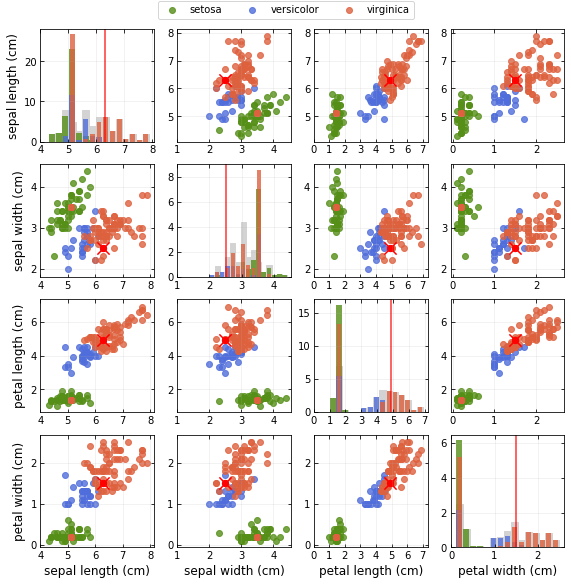

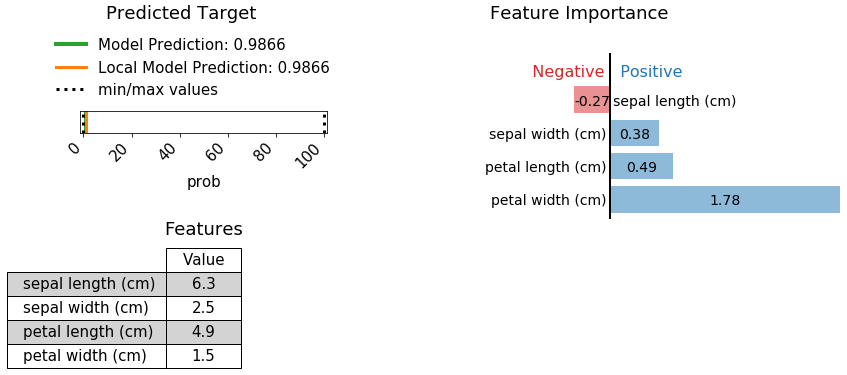

##############################
penalization_thetas:  0.5
R2:  0.5391061452513968
MSE:  0.36666666666666664
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 1.0000
(4, 3)
probabilities: [2.9695594e-08 9.9354035e-01 6.4597344e-03]
probabilities:  [1 2 0]
betas_document len: 4


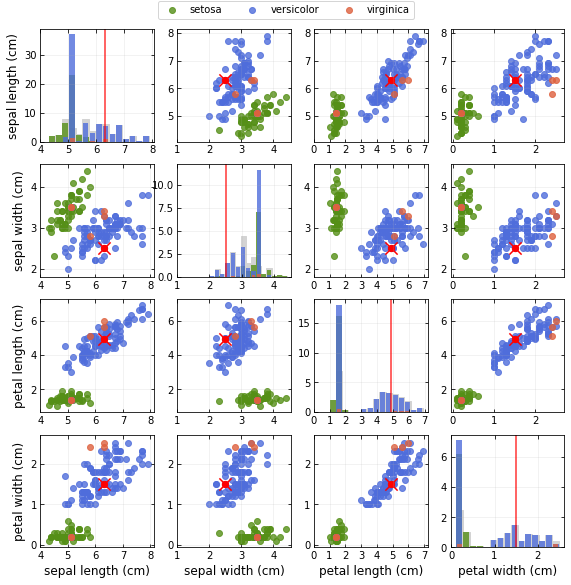

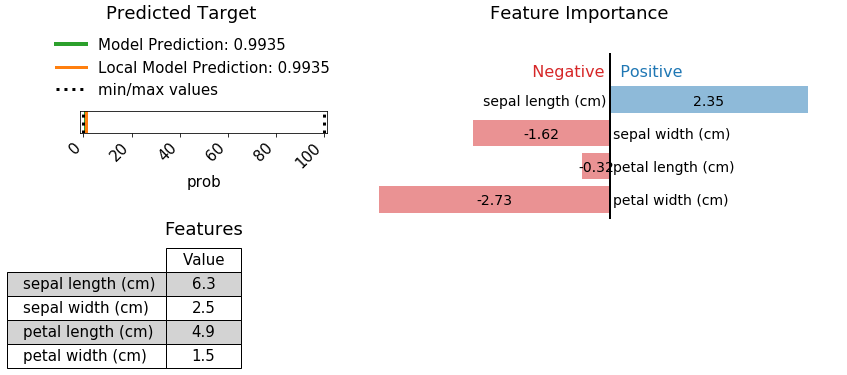

##############################
penalization_thetas:  0.75
R2:  0.7486033519553074
MSE:  0.2
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 2.0000
(4, 3)
probabilities: [8.5474322e-11 4.9040614e-06 9.9999511e-01]
probabilities:  [2 1 0]
betas_document len: 4


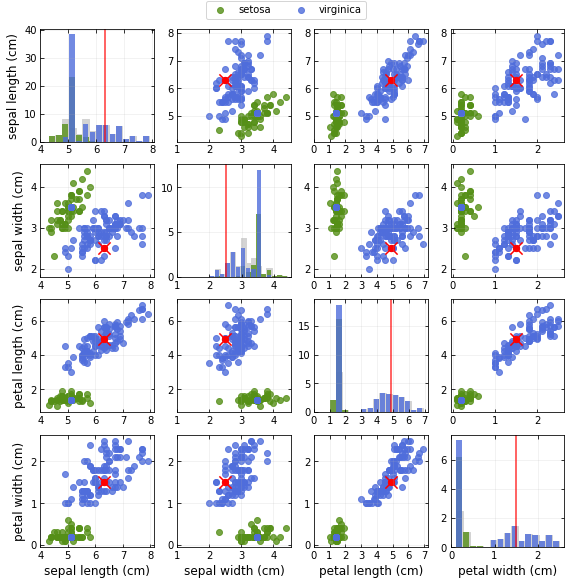

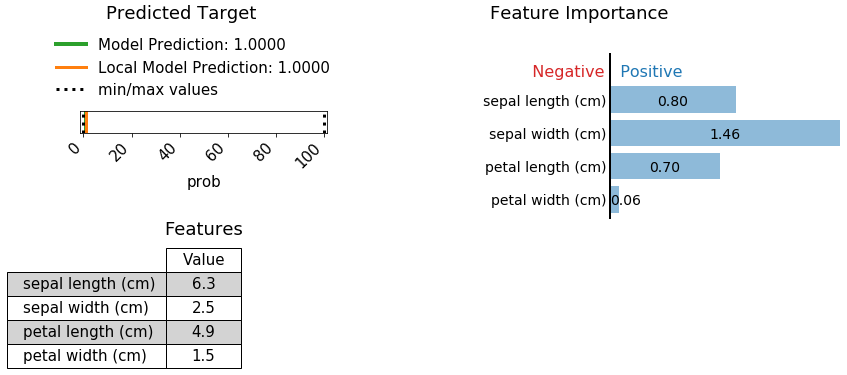

##############################
penalization_thetas:  1.0
R2:  0.24581005586592197
MSE:  0.6
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 2.0000
(4, 3)
probabilities: [0.00269266 0.00527278 0.9920346 ]
probabilities:  [2 1 0]
betas_document len: 4


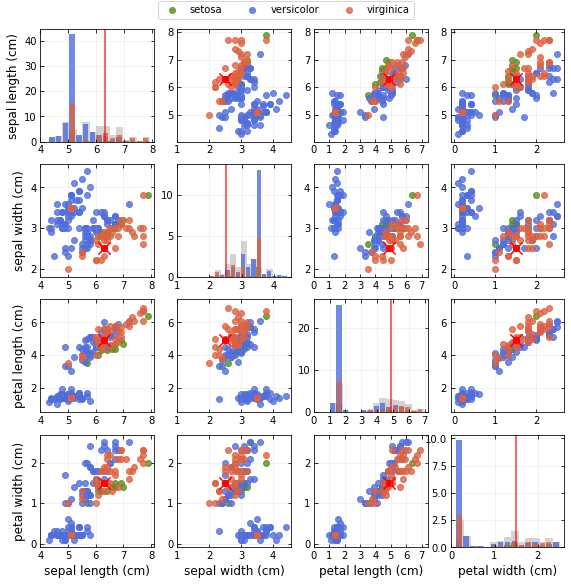

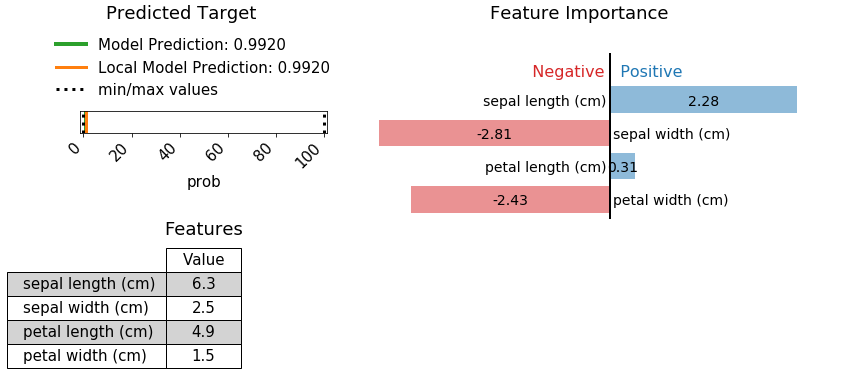

##############################
penalization_thetas:  2.0
R2:  0.4134078212290505
MSE:  0.4666666666666667
x_explain: [[6.3 2.5 4.9 1.5]]
y_explain: 1
Predict y: 1.0000
(4, 3)
probabilities: [0.00856552 0.9877989  0.00363553]
probabilities:  [1 0 2]
betas_document len: 4


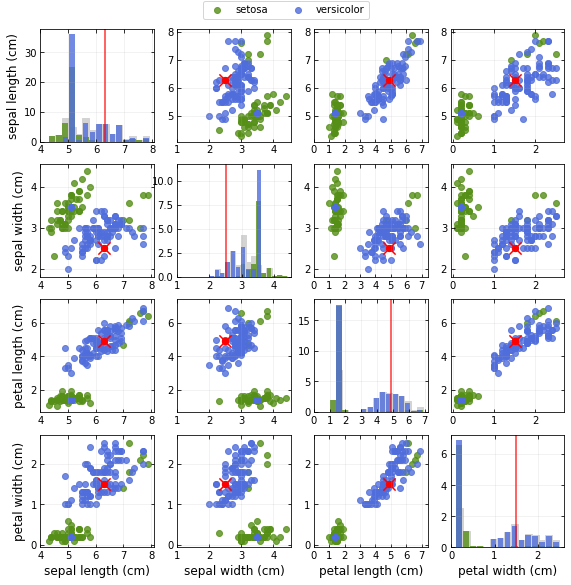

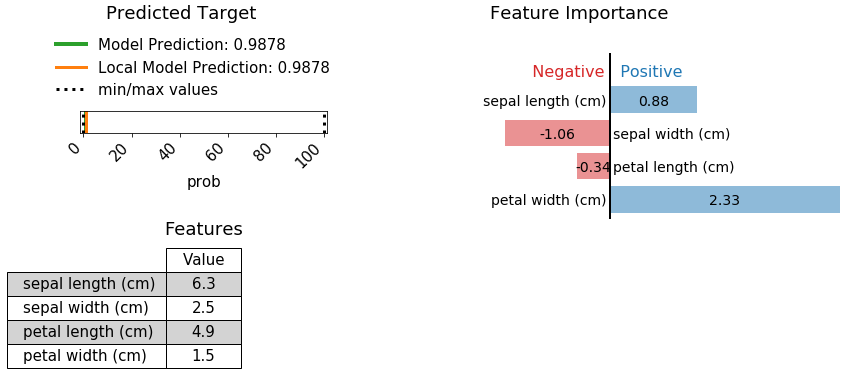

In [7]:
for e in [0.0, 0.01, 0.1, 0.2, 0.5, 0.75, 1.0, 2.0]:
    print('#'*30)
    print("penalization_thetas: ", e)
    explain(e)
    plt.show()

Thank you!